In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
import numpy as np
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt


Keys in the .mat file:
camera_motion, shape: (7500, 1214)
camera_streaming, shape: (7500, 1356)
extrusion, shape: (7500, 2816)
idle, shape: (7500, 2490)
masuta_when_idle, shape: (7500, 1165)
masuta_with_camera, shape: (7500, 1157)
mirai_extrusion, shape: (7500, 2200)
mirai_idle, shape: (7500, 1534)
mirai_loader, shape: (7500, 792)
mirai_with_camera, shape: (7500, 910)
mirai_with_router, shape: (7500, 782)
mirai_with_voice, shape: (7500, 1018)
reboot, shape: (7500, 2288)
router, shape: (7500, 2469)
router_ftp, shape: (7500, 640)
voice_assistant, shape: (7500, 2391)


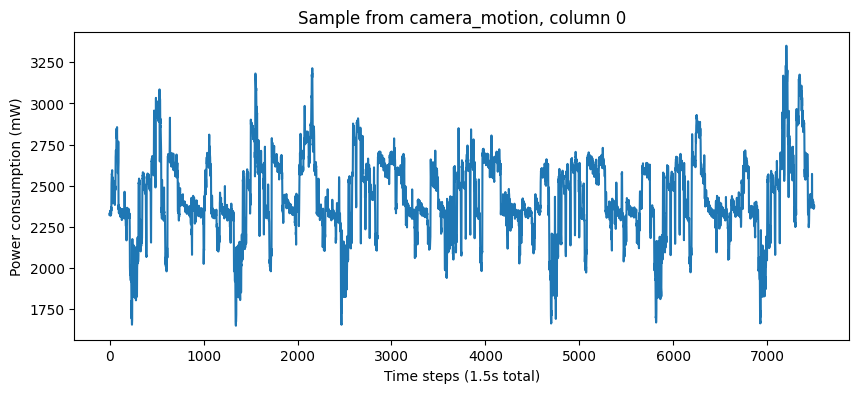

In [ ]:

# 1) Load the dataset
mat_file = os.path.join("Data", "Botnet_Detection.mat")
data = sio.loadmat(mat_file)

# 2) Print keys and shapes
print("Keys in the .mat file:")
for key in data.keys():
    if key.startswith('__'):
        continue
    arr = data[key]
    print(f"{key}, shape: {arr.shape}")

# 3) Visualize a portion of the data from a selected key
key_to_plot = 'camera_motion'  # example
sample_index = 0
sample_signal = data[key_to_plot][:, sample_index]  # shape (7500,)
plt.figure(figsize=(10,4))
plt.plot(sample_signal)
plt.title(f"Sample from {key_to_plot}, column {sample_index}")
plt.xlabel("Time steps (1.5s total)")
plt.ylabel("Power consumption (mW)")
plt.show()


In [3]:
import numpy as np

# We have keys relevant to the camera device:
# - camera_motion (7500, 1214)
# - camera_streaming (7500, 1356)
# - mirai_with_camera (7500, 910)
# - masuta_with_camera (7500, 1157)
# - mirai_loader (7500, 792)  <-- used for leftover
# - idle (7500, 2490)
# - reboot (7500, 2288)

# --- Class 1: Service (label=0) ---
# We'll combine camera_motion(1214) + camera_streaming(986) = 2200
cam_service_motion = data['camera_motion'][:, :1214]
needed_from_stream = 2200 - 1214  # 986
cam_service_stream = data['camera_streaming'][:, :986]
camera_service = np.hstack([cam_service_motion, cam_service_stream])  # (7500, 2200)

# --- Class 2: Reboot (label=1) ---
camera_reboot = data['reboot'][:, :2200]  # (7500, 2200)

# --- Class 3: Idle (label=2) ---
camera_idle = data['idle'][:, :2200]  # (7500, 2200)

# --- Class 4: Botnet (label=3) ---
# We can combine mirai_with_camera(910) + masuta_with_camera(1157) = 2067
# Then we still need 133 more to reach 2200, so we can take 133 from mirai_loader
cam_botnet_mirai  = data['mirai_with_camera'][:, :910]
cam_botnet_masuta = data['masuta_with_camera'][:, :1157]
needed_loader     = 2200 - (910 + 1157)  # 133
cam_botnet_loader = data['mirai_loader'][:, :133]

camera_botnet = np.hstack([cam_botnet_mirai, cam_botnet_masuta, cam_botnet_loader])  # (7500, 2200)

# Combine all four classes
combined_camera = np.hstack([
    camera_service,
    camera_reboot,
    camera_idle,
    camera_botnet
])  # shape: (7500, 8800)

labels_camera = np.concatenate([
    np.full(2200, 0),  # Service
    np.full(2200, 1),  # Reboot
    np.full(2200, 2),  # Idle
    np.full(2200, 3)   # Botnet
])

print("combined_camera shape:", combined_camera.shape)  # (7500, 8800)
print("labels_camera shape:", labels_camera.shape)      # (8800,)


combined_camera shape: (7500, 8800)
labels_camera shape: (8800,)


In [4]:
# For the router device, as per the baseline readme:
# - router (7500, 2469)
# - router_ftp (7500, 640)
# - mirai_with_router (7500, 782)
# - mirai_idle (7500, 1534)
# - mirai_loader (7500, 792)
# - idle (7500, 2490)
# - reboot (7500, 2288)

# --- Class 1: Service (label=0) ---
# Combine router(1980) + router_ftp(220) = 2200
router_service_main = data['router'][:, :1980]
router_service_ftp  = data['router_ftp'][:, :220]
router_service = np.hstack([router_service_main, router_service_ftp])  # (7500, 2200)

# --- Class 2: Reboot (label=1) ---
router_reboot = data['reboot'][:, :2200]

# --- Class 3: Idle (label=2) ---
router_idle = data['idle'][:, :2200]

# --- Class 4: Botnet (label=3) ---
# Combine mirai_with_router(700) + mirai_idle(800) + mirai_loader(700) = 2200
r_bot_mirai_router = data['mirai_with_router'][:, :700]
r_bot_mirai_idle   = data['mirai_idle'][:, :800]
r_bot_mirai_loader = data['mirai_loader'][:, :700]
router_botnet = np.hstack([r_bot_mirai_router, r_bot_mirai_idle, r_bot_mirai_loader])  # (7500, 2200)

combined_router = np.hstack([
    router_service,
    router_reboot,
    router_idle,
    router_botnet
])  # (7500, 8800)

labels_router = np.concatenate([
    np.full(2200, 0),
    np.full(2200, 1),
    np.full(2200, 2),
    np.full(2200, 3)
])

print("combined_router shape:", combined_router.shape)  # (7500, 8800)
print("labels_router shape:", labels_router.shape)      # (8800,)


combined_router shape: (7500, 8800)
labels_router shape: (8800,)


In [5]:
# For the voice device, we have:
# - voice_assistant (7500, 2391)
# - mirai_with_voice (7500, 1018)
# - Possibly extrusions or idle if needed
# - idle (7500, 2490), reboot(7500, 2288)
# - If there's no direct "masuta_with_voice", we can use 'masuta_when_idle' or 'mirai_extrusion' for leftover

# --- Class 1: Service (label=0) ---
# Just take 2200 from voice_assistant
voice_service = data['voice_assistant'][:, :2200]

# --- Class 2: Reboot (label=1) ---
voice_reboot = data['reboot'][:, :2200]

# --- Class 3: Idle (label=2) ---
voice_idle = data['idle'][:, :2200]

# --- Class 4: Botnet (label=3) ---
# We have mirai_with_voice(1018). We need 1182 more to reach 2200.
# Let's use 'mirai_extrusion' or 'extrusion' for leftover.
# For instance, let's pick 1182 from mirai_extrusion(2200).
voice_bot_mirai = data['mirai_with_voice'][:, :1018]
needed_voice_bot = 2200 - 1018  # 1182
voice_bot_extrusion = data['mirai_extrusion'][:, :1182]

voice_botnet = np.hstack([voice_bot_mirai, voice_bot_extrusion])  # (7500, 2200)

combined_voice = np.hstack([
    voice_service,
    voice_reboot,
    voice_idle,
    voice_botnet
])  # (7500, 8800)

labels_voice = np.concatenate([
    np.full(2200, 0),
    np.full(2200, 1),
    np.full(2200, 2),
    np.full(2200, 3)
])

print("combined_voice shape:", combined_voice.shape)  # (7500, 8800)
print("labels_voice shape:", labels_voice.shape)      # (8800,)


combined_voice shape: (7500, 8800)
labels_voice shape: (8800,)


In [6]:
device_data = {
    'camera': {
        'X': combined_camera,
        'Y': labels_camera
    },
    'router': {
        'X': combined_router,
        'Y': labels_router
    },
    'voice': {
        'X': combined_voice,
        'Y': labels_voice
    }
}

for dev in device_data:
    X_shape = device_data[dev]['X'].shape
    Y_shape = device_data[dev]['Y'].shape
    print(f"{dev} -> X: {X_shape}, Y: {Y_shape}")


camera -> X: (7500, 8800), Y: (8800,)
router -> X: (7500, 8800), Y: (8800,)
voice -> X: (7500, 8800), Y: (8800,)


In [7]:
from torch.utils.data import Dataset, random_split

class RouterDataset(Dataset):
    def __init__(self, data_array, label_array, normalize=True):
        # data_array: (7500, 8800) -> transpose -> (8800, 7500)
        self.X = data_array.T.astype(np.float32)  # (N, 7500)
        self.X = np.expand_dims(self.X, axis=1)   # (N, 1, 7500)
        
        if normalize:
            mean = self.X.mean(axis=-1, keepdims=True)
            std  = self.X.std(axis=-1, keepdims=True) + 1e-8
            self.X = (self.X - mean) / std
        
        self.Y = label_array.astype(np.int64)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        import torch
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.Y[idx], dtype=torch.long)
        )

# Build the full datasets
router_dataset = RouterDataset(combined_router, labels_router)
print("Router dataset size:", len(router_dataset))
# Split
dataset_size = len(router_dataset)
train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)
test_size  = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    router_dataset, [train_size, val_size, test_size]
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Router dataset size: 8800
Train: 6160, Val: 1320, Test: 1320
